In [93]:
import numpy as np
import pickle
from scipy.stats import zscore

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

In [82]:
# load the data ~5gb
data = pickle.load(open('data/dataset.pickle', 'rb'))
print(data['info'])

responses: (11983 neurons x 7018 timebins) responses for each neuron at each time 
run_speed: (7018 timebins x 1) run speed for mouse at each time 
neuron_pos: (11983 neurons x 3) xyz position for each neuron 
pupil_area: (7018 timebins x 1) area of pupil for mouse at each time 
pupil_pos: (7018 timebins x 2) xy position of pupil for mouse at each time 
behavior_embedding: (7018 timebins x 1000) the behavior embedded in a vector size 1000 at each time 
movie: (7018 timebins x 240 x 320) the behavior movie at each time (corresponding to the embedding) 
movie_mask: (240 x 320 x 1) a mask to generate the movie, not important 
info: this text 



In [83]:
# how should we bucket the regions?
def describe(arr):
    return f'size: {arr.shape}, min: {np.min(arr)}, max: {np.max(arr)}, mean: {np.mean(arr)}, std: {np.std(arr)}'
print(describe(data['neuron_pos'][0]))
print(describe(data['neuron_pos'][1]))
print(describe(data['neuron_pos'][2]))

# Lets look at 10 < x < 1000, 10 < y < 1000, -390 < z < -150
#   Then, lets look at 27 different buckets:
#       - for x and y: 10 to 340, 340 to 670, 670 to 1000 (buckets of 330 uM)
#       - for z: -390 to -310, -310 to -230, -230 to -150 (buckets of 80 uM)

zscored_X = zscore(data['responses'], axis=1)

size: (11983,), min: 4.0, max: 1010.0, mean: 561.0577484770091, std: 269.60041489847873
size: (11983,), min: 4.0, max: 1012.0, mean: 452.0052574480514, std: 281.6145349225211
size: (11983,), min: -390.0, max: -150.0, mean: -275.8608028039723, std: 75.92754258632117


In [84]:
# data_bucket[i][j][k] is a list corresponding to: 
#   x: 10 + 330i < x < 10 + 330(i + 1)
#   y: 10 + 330i < y < 10 + 330(i + 1)
#   z: -390 + 80i < z < -390 + 80(i + 1)

data_buckets = [[[[], [], []], [[], [], []], [[], [], []]], 
                [[[], [], []], [[], [], []], [[], [], []]], 
                [[[], [], []], [[], [], []], [[], [], []]]]

def pos_to_bucket(x, y, z):    
    if (x <= 10 or x >= 1000) or (y <= 10 or y >= 1000) or (z <= -390 or z >= -150):
        return None
    return (int(x - 10) // 330), (int(y - 10) // 330), (int(z - (-390)) // 80)
    
    
for neuron_index in range(data['neuron_pos'].shape[1]):
    x, y, z = data['neuron_pos'][:, neuron_index]
    pos_index = pos_to_bucket(x, y, z)
    if pos_index: 
        data_buckets[pos_index[0]][pos_index[1]][pos_index[2]].append(neuron_index)

sum = 0
for i in range(len(data_buckets)):
    for j in range(len(data_buckets[i])):
        for k in range(len(data_buckets[i][j])):
            length = len(data_buckets[i][j][k])
            sum += length
            print(f'{i}{j}{k}: {length}', end='  ')
print()
print('total:', sum)

# We see that bucket 020 is particularly smol. Let's ignore 020 and sample 132 neurons from each bucket.

000: 326  001: 415  002: 203  010: 132  011: 319  012: 172  020: 63  021: 201  022: 169  100: 423  101: 565  102: 316  110: 380  111: 523  112: 291  120: 240  121: 434  122: 259  200: 500  201: 660  202: 342  210: 468  211: 590  212: 324  220: 265  221: 352  222: 240  
total: 9172


In [85]:
# Now let's run the experiment!
N_TRIALS = 10
Y = data['run_speed']
TRAIN_TEST_SPLIT = 6500 # Number of datapoints to train on

score_buckets = [[[[], [], []], [[], [], []], [[], [], []]], 
                [[[], [], []], [[], [], []], [[], [], []]], 
                [[[], [], []], [[], [], []], [[], [], []]]]

for i in range(len(data_buckets)):
    for j in range(len(data_buckets[i])):
        for k in range(len(data_buckets[i][j])):
            print(f'{i}{j}{k}', end=' ')
            for trials in range(N_TRIALS):
                bin = data_buckets[i][j][k]
                sample_size = min(132, len(bin))
                bin_132 = np.random.choice(bin, size=sample_size, replace=False) # select 132 indexes from the data
                bin_X = zscored_X[bin_132].T # get the data corresponding to a bin
                
                train_X = bin_X[:TRAIN_TEST_SPLIT,]
                train_Y = Y[:TRAIN_TEST_SPLIT,]
                test_X = bin_X[TRAIN_TEST_SPLIT:,]
                test_Y = Y[TRAIN_TEST_SPLIT:,]
                
                linear_regression = Ridge(alpha=10000).fit(train_X, train_Y)
                score_buckets[i][j][k].append(linear_regression.score(train_X, train_Y))      

000 001 002 010 011 012 020 021 022 100 101 102 110 111 112 120 121 122 200 201 202 210 211 212 220 221 222 

In [100]:
# Failure, buckets are too small to see anything!
labels = []
for i in range(len(score_buckets)):
    for j in range(len(score_buckets[i])):
        for k in range(len(score_buckets[i][j])):
            print(f'{i}{j}{k}: {np.mean(score_buckets[i][j][k])}')
            labels.append(score_buckets[i][j][k])

000: 0.3317024825560294
001: 0.4108641474151842
002: 0.2742373144927747
010: 0.2935571966535484
011: 0.3452610265180893
012: 0.2902828665191079
020: 0.16883279877247306
021: 0.3233614650664598
022: 0.2588635939202451
100: 0.3310392277440529
101: 0.407542179199503
102: 0.3101571080630888
110: 0.3289723069945765
111: 0.35633248727917244
112: 0.3281123296676631
120: 0.3808405455908396
121: 0.3146242460341802
122: 0.31083183944145665
200: 0.40298584258978876
201: 0.3524486767118229
202: 0.2859281632396232
210: 0.312734898696783
211: 0.3453662378790906
212: 0.29367144636046794
220: 0.3111151118353708
221: 0.31602625839411724
222: 0.2787265858919434


[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2] [0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2] [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]
['0.29', '0.36', '0.29', '0.29', '0.36', '0.3', '0.17', '0.34', '0.26', '0.36', '0.44', '0.3', '0.38', '0.42', '0.34', '0.42', '0.3', '0.35', '0.43', '0.37', '0.24', '0.3', '0.35', '0.32', '0.31', '0.34', '0.27']


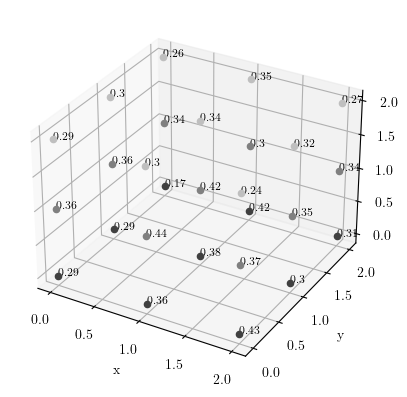

In [125]:
# data: coordinates of nodes and links
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from numpy.random import rand
from IPython.display import HTML
from matplotlib import animation

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

xn = [0] * 9 + [1] * 9 + [2] * 9
yn = ([0] * 3 + [1] * 3 + [2] * 3) * 3
zn = [0, 1, 2] * 9
color = [[(x + 1) / 4, (x + 1) / 4, (x + 1) / 4, 1] for x in zn]
print(xn, yn, zn)
text_labels = [str(round(x[0], 2)) for x in labels] 
print(text_labels)
xyzn = zip(xn, yn, zn)

fig = figure()
ax = fig.add_subplot(projection='3d')

for i in range(len(xn)): #plot each point + it's index as text above
    ax.scatter(xn[i], yn[i], zn[i], color=color[i]) 
    ax.text(xn[i], yn[i], zn[i], text_labels[i], size=8, zorder=1, color='k') 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.savefig('figures/failed.png')
plt.show()


In [97]:
# new attempt!
x_sorted = np.argsort(data['neuron_pos'][0, :])
y_sorted = np.argsort(data['neuron_pos'][1, :])
z_sorted = np.argsort(data['neuron_pos'][2, :])


TRAIN_TEST_SPLIT = 5000

def test_index_arr(index_arr, X, Y):
    bin_X = X[index_arr].T
    train_X = bin_X[:TRAIN_TEST_SPLIT,]
    train_Y = Y[:TRAIN_TEST_SPLIT,]
    test_X = bin_X[TRAIN_TEST_SPLIT:,]
    test_Y = Y[TRAIN_TEST_SPLIT:,]

    linear_regression = RidgeCV(alphas=[10**x for x in range(8)]).fit(train_X, train_Y)
    print(linear_regression.score(test_X, test_Y))

def test_dim(dim_index_arr, X, Y):
    N_HALF = len(dim_index_arr) // 2 
    
    smol = dim_index_arr[:N_HALF]
    bigg = dim_index_arr[N_HALF:]
    
    print(len(smol), len(bigg))
    
    test_index_arr(smol, X, Y)
    test_index_arr(bigg, X, Y)

print('x')
test_dim(x_sorted, zscored_X, Y)

print('y')
test_dim(y_sorted, zscored_X, Y)

print('z')
test_dim(z_sorted, zscored_X, Y)

    
# As you can see, I'm getting no big improvement here!

x
5991 5992
0.3767870897263167
0.3723108849536768
y
5991 5992
0.38686666003458614
0.33899104137565905
z
5991 5992
0.3795204329903181
0.35843806150300384
